<a href="https://colab.research.google.com/github/Yaminikanna18/bioinfo-learning/blob/main/week3_rnaseq_alignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
set -e
WORKDIR=/content/week3_rnaseq_alignment
mkdir -p $WORKDIR/{data,ref,results,plots}
echo "Created folders under $WORKDIR"
ls -la $WORKDIR


Created folders under /content/week3_rnaseq_alignment
total 24
drwxr-xr-x 6 root root 4096 Aug 30 11:27 .
drwxr-xr-x 1 root root 4096 Aug 30 11:27 ..
drwxr-xr-x 2 root root 4096 Aug 30 11:27 data
drwxr-xr-x 2 root root 4096 Aug 30 11:27 plots
drwxr-xr-x 2 root root 4096 Aug 30 11:27 ref
drwxr-xr-x 2 root root 4096 Aug 30 11:27 results


In [ ]:
%%bash
set -e
apt-get update -qq
apt-get install -y -qq unzip wget samtools fastqc subread

# Install STAR static binary (copy from source archive)
cd /content
STAR_VER=2.7.11b
wget -q https://github.com/alexdobin/STAR/archive/${STAR_VER}.tar.gz -O STAR-${STAR_VER}.tar.gz
tar -xzf STAR-${STAR_VER}.tar.gz
cp STAR-${STAR_VER}/bin/Linux_x86_64_static/STAR /usr/local/bin/
chmod +x /usr/local/bin/STAR

# quick checks
echo "STAR version:" && STAR --version || true
echo "samtools version:" && samtools --version | head -n 1 || true
echo "featureCounts:" && featureCounts -v || true
echo "FastQC:" && fastqc --version || true


Selecting previously unselected package default-jre-headless.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../00-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Selecting previously unselected package libxtst6:amd64.
Preparing to unpack .../01-libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-11-jre:amd64.
Preparing to unpack .../02-openjdk-11-jre_11.0.28+6-1ubuntu1~22.04.1_amd64.deb ...
Unpacking openjdk-11-jre:amd64 (11.0.28+6-1ubuntu1~22.04.1) ...
Selecting previously unselected package default-jre.
Preparing to unpack .../03-default-jre_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre (2:1.11-72build2) ...
Selecting previously unselected package libcommons-math3-java.
Preparing to unpack .../04-libcommons-math3-java_3.6.1-3_all.deb ...
Unpacking libcommons-math3-java (3.6.1-3) ...
Select

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

featureCounts v2.0.3



In [ ]:
%%bash
set -e
cd /content/week3_rnaseq_alignment/data

# Example single-end ENA file (small demo)
wget -c https://ftp.sra.ebi.ac.uk/vol1/fastq/ERR458/ERR458493/ERR458493.fastq.gz -O sample.fastq.gz

# quick sanity check (first 4 reads)
echo "First 8 lines of sample.fastq.gz:"
gunzip -c sample.fastq.gz | head -n 8


First 8 lines of sample.fastq.gz:
@ERR458493.1 DHKW5DQ1:219:D0PT7ACXX:1:1101:1724:2080/1
CGCAAGACAAGGCCCAAACGAGAGATTGAGCCCAATCGGCAGTGTAGTGAA
+
B@@FFFFFHHHGHJJJJJJIJJGIGIIIGI9DGGIIIEIGIIFHHGGHJIB
@ERR458493.2 DHKW5DQ1:219:D0PT7ACXX:1:1101:2179:2231/1
ACTAATCATCAACAAAACAATGCAATTCAAGACCATCGTCGCTGCCTTCGC
+
B@=DDFFFHHHHHJJJJIJJJJJJIJJJJJJJJJJJJJJJJJJJJIJJJJI


--2025-08-30 11:31:49--  https://ftp.sra.ebi.ac.uk/vol1/fastq/ERR458/ERR458493/ERR458493.fastq.gz
Resolving ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)... 193.62.193.165
Connecting to ftp.sra.ebi.ac.uk (ftp.sra.ebi.ac.uk)|193.62.193.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59532325 (57M) [application/x-gzip]
Saving to: ‘sample.fastq.gz’

     0K .......... .......... .......... .......... ..........  0%  113K 8m32s
    50K .......... .......... .......... .......... ..........  0%  227K 6m24s
   100K .......... .......... .......... .......... ..........  0%  227K 5m41s
   150K .......... .......... .......... .......... ..........  0%  108M 4m16s
   200K .......... .......... .......... .......... ..........  0%  164M 3m24s
   250K .......... .......... .......... .......... ..........  0%  227K 3m33s
   300K .......... .......... .......... .......... ..........  0%  146M 3m2s
   350K .......... .......... .......... .......... ..........  0%  176M 2m39

In [ ]:
%%bash
set -e
cd /content/week3_rnaseq_alignment/ref

ENSEMBL_REL=109
# chr22 FASTA
wget -c ftp://ftp.ensembl.org/pub/release-${ENSEMBL_REL}/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.22.fa.gz -O chr22.fa.gz
# full GTF; we will extract chr22 lines
wget -c ftp://ftp.ensembl.org/pub/release-${ENSEMBL_REL}/gtf/homo_sapiens/Homo_sapiens.GRCh38.${ENSEMBL_REL}.gtf.gz -O Hs.GRCh38.gtf.gz

gunzip -c chr22.fa.gz > chr22.fa
gunzip -c Hs.GRCh38.gtf.gz | awk '$1=="22" {print}' > chr22.gtf

ls -lh


total 142M
-rw-r--r-- 1 root root 50M Aug 30 11:40 chr22.fa
-rw-r--r-- 1 root root 11M Aug 30 11:39 chr22.fa.gz
-rw-r--r-- 1 root root 30M Aug 30 11:40 chr22.gtf
-rw-r--r-- 1 root root 52M Aug 30 11:40 Hs.GRCh38.gtf.gz


--2025-08-30 11:39:53--  ftp://ftp.ensembl.org/pub/release-109/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.chromosome.22.fa.gz
           => ‘chr22.fa.gz’
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.169
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.169|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/release-109/fasta/homo_sapiens/dna ... done.
==> SIZE Homo_sapiens.GRCh38.dna.chromosome.22.fa.gz ... 11389810
==> PASV ... done.    ==> RETR Homo_sapiens.GRCh38.dna.chromosome.22.fa.gz ... done.
Length: 11389810 (11M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  0%  111K 1m40s
    50K .......... .......... .......... .......... ..........  0%  230K 74s
   100K .......... .......... .......... .......... ..........  1% 54.3M 49s
   150K .......... .......... .......... .......... ..........  1%  231K 48s
   200K .......... .......... ...

In [ ]:
%%bash
set -e
cd /content/week3_rnaseq_alignment/ref
mkdir -p star_index_chr22

# sjdbOverhang = read_length - 1 ; set 99 for common 100bp reads (safe)
STAR --runThreadN 2 \
     --runMode genomeGenerate \
     --genomeDir star_index_chr22 \
     --genomeFastaFiles chr22.fa \
     --sjdbGTFfile chr22.gtf \
     --sjdbOverhang 99

echo "STAR index built at $(realpath star_index_chr22)"


	STAR --runThreadN 2 --runMode genomeGenerate --genomeDir star_index_chr22 --genomeFastaFiles chr22.fa --sjdbGTFfile chr22.gtf --sjdbOverhang 99
	STAR version: 2.7.11b   compiled: 2024-01-25T16:12:02-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Aug 30 11:41:19 ..... started STAR run
Aug 30 11:41:19 ... starting to generate Genome files
Aug 30 11:41:20 ..... processing annotations GTF
Aug 30 11:41:20 ... starting to sort Suffix Array. This may take a long time...
Aug 30 11:41:21 ... sorting Suffix Array chunks and saving them to disk...
Aug 30 11:42:12 ... loading chunks from disk, packing SA...
Aug 30 11:42:13 ... finished generating suffix array
Aug 30 11:42:13 ... generating Suffix Array index
Aug 30 11:42:36 ... completed Suffix Array index
Aug 30 11:42:36 ..... inserting junctions into the genome indices
Aug 30 11:42:57 ... writing Genome to disk ...
Aug 30 11:42:57 ... writing Suffix Array to disk ...
Aug 30 11:42:58 ... writing SAindex to disk
Aug 30 11:43:26 ..... fi

!!!!! WARNING: --genomeSAindexNbases 14 is too large for the genome size=50818468, which may cause seg-fault at the mapping step. Re-run genome generation with recommended --genomeSAindexNbases 11


In [ ]:
%%bash
set -e
cd /content/week3_rnaseq_alignment/data
fastqc -o ../results sample.fastq.gz || true
ls -lh ../results/*.zip ../results/*_fastqc.html


Analysis complete for sample.fastq.gz
-rw-r--r-- 1 root root 632K Aug 30 11:45 ../results/sample_fastqc.html
-rw-r--r-- 1 root root 453K Aug 30 11:45 ../results/sample_fastqc.zip


Started analysis of sample.fastq.gz
Approx 5% complete for sample.fastq.gz
Approx 10% complete for sample.fastq.gz
Approx 15% complete for sample.fastq.gz
Approx 20% complete for sample.fastq.gz
Approx 25% complete for sample.fastq.gz
Approx 30% complete for sample.fastq.gz
Approx 35% complete for sample.fastq.gz
Approx 40% complete for sample.fastq.gz
Approx 45% complete for sample.fastq.gz
Approx 50% complete for sample.fastq.gz
Approx 55% complete for sample.fastq.gz
Approx 60% complete for sample.fastq.gz
Approx 65% complete for sample.fastq.gz
Approx 70% complete for sample.fastq.gz
Approx 75% complete for sample.fastq.gz
Approx 80% complete for sample.fastq.gz
Approx 85% complete for sample.fastq.gz
Approx 90% complete for sample.fastq.gz
Approx 95% complete for sample.fastq.gz


In [ ]:
%%bash
set -e
cd /content/week3_rnaseq_alignment

STAR --runThreadN 2 \
     --genomeDir ref/star_index_chr22 \
     --readFilesIn data/sample.fastq.gz \
     --readFilesCommand zcat \
     --outSAMtype BAM SortedByCoordinate \
     --outFileNamePrefix results/sample_

# rename for convenience
mv results/sample_Aligned.sortedByCoord.out.bam results/sample.sorted.bam

# index and get flagstat
samtools index results/sample.sorted.bam
samtools flagstat results/sample.sorted.bam > results/sample_flagstat.txt
cat results/sample_flagstat.txt


	STAR --runThreadN 2 --genomeDir ref/star_index_chr22 --readFilesIn data/sample.fastq.gz --readFilesCommand zcat --outSAMtype BAM SortedByCoordinate --outFileNamePrefix results/sample_
	STAR version: 2.7.11b   compiled: 2024-01-25T16:12:02-05:00 :/home/dobin/data/STAR/STARcode/STAR.master/source
Aug 30 11:50:49 ..... started STAR run
Aug 30 11:50:49 ..... loading genome
Aug 30 11:50:50 ..... started mapping
Aug 30 11:54:50 ..... finished mapping
Aug 30 11:54:50 ..... started sorting BAM
Aug 30 11:54:51 ..... finished successfully
1656 + 0 in total (QC-passed reads + QC-failed reads)
1224 + 0 primary
432 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
0 + 0 primary duplicates
1656 + 0 mapped (100.00% : N/A)
1224 + 0 primary mapped (100.00% : N/A)
0 + 0 paired in sequencing
0 + 0 read1
0 + 0 read2
0 + 0 properly paired (N/A : N/A)
0 + 0 with itself and mate mapped
0 + 0 singletons (N/A : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

In [ ]:
%%bash
set -e
cd /content/week3_rnaseq_alignment

featureCounts -T 2 -t exon -g gene_id -a ref/chr22.gtf -o results/gene_counts.txt results/sample.sorted.bam

# show head
head -n 30 results/gene_counts.txt


# Program:featureCounts v2.0.3; Command:"featureCounts" "-T" "2" "-t" "exon" "-g" "gene_id" "-a" "ref/chr22.gtf" "-o" "results/gene_counts.txt" "results/sample.sorted.bam" 
Geneid	Chr	Start	End	Strand	Length	results/sample.sorted.bam
ENSG00000231565	22	15611759	15613096	-	1338	0
ENSG00000215270	22	15854195	15855243	-	1049	0
ENSG00000198445	22	16590751	16592810	-	2060	0
ENSG00000279442	22	15298378	15304556	-	6179	0
ENSG00000253460	22;22	16921443;16922125	16921753;16922173	-;-	360	0
ENSG00000189295	22;22;22;22;22;22;22;22;22;22;22;22;22	16654066;16659497;16659858;16661476;16669462;16669464;16670217;16670217;16671518;16671518;16673600;16675123;16675123	16654076;16659628;16659969;16661555;16669620;16669620;16670261;16670261;16671588;16671588;16673752;16675452;16675540	-;-;-;-;-;-;-;-;-;-;-;-;-	1181	0
ENSG00000220248	22	16857619	16860718	-	3100	0
ENSG00000233995	22;22;22;22;22	16572027;16572708;16573044;16573422;16574466	16572150;16572753;16573212;16573527;16574637	+;+;+;+;+	617	0
ENSG00000


        ==========     _____ _    _ ____  _____  ______          _____  
        =====         / ____| |  | |  _ \|  __ \|  ____|   /\   |  __ \ 
          =====      | (___ | |  | | |_) | |__) | |__     /  \  | |  | |
            ====      \___ \| |  | |  _ <|  _  /|  __|   / /\ \ | |  | |
              ====    ____) | |__| | |_) | | \ \| |____ / ____ \| |__| |
        ==========   |_____/ \____/|____/|_|  \_\______/_/    \_\_____/
	  v2.0.3

//========================== featureCounts setting ===========================\\
||                                                                            ||
||             Input files : 1 BAM file                                       ||
||                                                                            ||
||                           sample.sorted.bam                                ||
||                                                                            ||
||             Output file : gene_counts.txt                     

,Geneid,Chr,Start,End,Strand,Length,results/sample.sorted.bam
0,ENSG00000231565,22,15611759,15613096,-,1338,0
1,ENSG00000215270,22,15854195,15855243,-,1049,0
2,ENSG00000198445,22,16590751,16592810,-,2060,0
3,ENSG00000279442,22,15298378,15304556,-,6179,0
4,ENSG00000253460,22;22,16921443;16922125,16921753;16922173,-;-,360,0


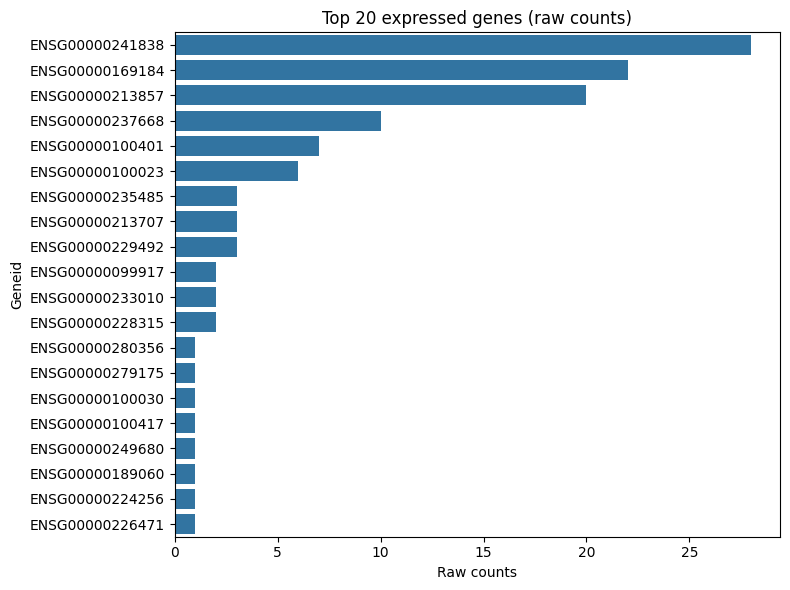

saved: /content/week3_rnaseq_alignment/results/gene_counts_sample.csv


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS = Path('/content/week3_rnaseq_alignment/results')
counts_file = RESULTS / 'gene_counts.txt'

# featureCounts: comment lines start with #, header present
df = pd.read_csv(counts_file, sep='\t', comment='#', header=0)
# 'Geneid' is first col; sample counts in the last column
sample_col = df.columns[-1]
display(df.head())

# make top20 barplot
top20 = df[['Geneid', sample_col]].nlargest(20, sample_col).set_index('Geneid')
plt.figure(figsize=(8,6))
sns.barplot(x=top20[sample_col].values, y=top20.index)
plt.xlabel('Raw counts')
plt.title('Top 20 expressed genes (raw counts)')
plt.tight_layout()
plt.savefig('/content/week3_rnaseq_alignment/plots/top20_genes.png', dpi=150)
plt.show()

# Save a small CSV with gene counts for inspection
df[['Geneid', sample_col]].to_csv(RESULTS / 'gene_counts_sample.csv', index=False)
print("saved:", RESULTS / 'gene_counts_sample.csv')


In [10]:
%%bash
set -e
cd /content/week3_rnaseq_alignment
cat > README.md <<'EOF'
# Week 3 — RNA-seq alignment & counting

Goal: FASTQ -> STAR alignment -> featureCounts gene matrix (chr22 demo).

Files:
- week3_rnaseq_alignment.ipynb — Colab notebook
- data/sample.fastq.gz — demo FASTQ
- ref/chr22.fa, ref/chr22.gtf — reference used
- results/sample.sorted.bam, results/gene_counts.txt
- plots/top20_genes.png

Notes:
- This demo uses chr22 for speed on Colab. For production, index full genome (requires more RAM).
- featureCounts used with -t exon -g gene_id; adjust -s for stranded libraries.
EOF

ls -la
echo "README.md created. Download notebook and push to GitHub when ready."


total 28
drwxr-xr-x 6 root root 4096 Aug 30 12:05 .
drwxr-xr-x 1 root root 4096 Aug 30 11:47 ..
drwxr-xr-x 2 root root 4096 Aug 30 11:31 data
drwxr-xr-x 2 root root 4096 Aug 30 12:02 plots
-rw-r--r-- 1 root root  524 Aug 30 12:05 README.md
drwxr-xr-x 3 root root 4096 Aug 30 11:43 ref
drwxr-xr-x 2 root root 4096 Aug 30 12:02 results
README.md created. Download notebook and push to GitHub when ready.
